# Analysez les ventes d'une librairie avec Python P6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import f_oneway
from scipy.stats import pearsonr
from scipy.stats import levene

I) Importation des données et nettoyage des DataFrames
1. DataFrame customers
2. DataFrame products
3. DataFrame transactions
    
II) Jointures DataFrames

III) Analyses
1. Chiffre d'affaires
        a) Indicateurs 
        b) Répartition par catégories
        c) Saisonnalite et tendance
        d) Répartition par références

2. Profils des clients
        a) Indicateurs
        b) Clients et âges
        c) Clients et genres

# I) Importation des données et nettoyage des DataFrames

## 1) Dataframe customers

In [2]:
customers = pd.read_csv('customers.csv')
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [3]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [4]:
customers.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [5]:
customers.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [6]:
customers.client_id.nunique()

8623

 Le dataframe customers ne contient pas de valeur abérrente ni manquante et les types sont cohérents

Afin de faciliter la lecture de nos futures analyses, nous créons une colonne âge  

In [7]:
from datetime import date
def annee_to_age(annee):
    aujourdhui = date.today()
    age = aujourdhui.year - annee
    return age
customers['age'] = customers['birth'].apply(annee_to_age)
customers.describe()

,birth,age
count,8623.000000,8623.000000
mean,1978.280877,44.719123
std,16.919535,16.919535
min,1929.000000,19.000000
25%,1966.000000,31.000000
50%,1979.000000,44.000000
75%,1992.000000,57.000000
max,2004.000000,94.000000


In [8]:
customers.head()

,client_id,sex,birth,age
0,c_4410,f,1967,56
1,c_7839,f,1975,48
2,c_1699,f,1984,39
3,c_5961,f,1962,61
4,c_5320,m,1943,80


## 2) DataFrame products

In [9]:
products = pd.read_csv('products.csv')
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [10]:
products.categ.value_counts()

0    2309
1     739
2     239
Name: categ, dtype: int64

In [11]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [12]:
products.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [13]:
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [14]:
products[products['price']== -1]

,id_prod,price,categ
731,T_0,-1.0,0


In [15]:
products = products[products['id_prod']!='T_0']

In [16]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3286 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 102.7+ KB


In [17]:
products.id_prod.nunique()

3286

Le dataframe products contenait une valeurs abérrente qui a été supprimé.
Le dataframe products ne contient pas de valeurs manquante et les types sont cohérents

## 3) DataFrame transactions

In [18]:
transactions = pd.read_csv('transactions.csv')
transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [19]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


In [20]:
transactions.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [21]:
transactions.describe()

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


In [22]:
transactions[transactions.date.str.contains('test')]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


Ces transactions correspondent aux tests que nous avions sur le produit dans le dataframe products T_0

In [23]:
transactions2 = transactions[transactions['id_prod']!='T_0']
transactions2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679332 non-null  object
 1   date        679332 non-null  object
 2   session_id  679332 non-null  object
 3   client_id   679332 non-null  object
dtypes: object(4)
memory usage: 25.9+ MB


La date apparait en object, nous la modifions en type date 

In [24]:
transactions2["date"] = pd.to_datetime(transactions2["date"], yearfirst= True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9248\940558989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions2["date"] = pd.to_datetime(transactions2["date"], yearfirst= True)


In [25]:
transactions2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 25.9+ MB


Le dataframe transactions contenait 200 valeurs "test" abérrentes qui ont été supprimé. 
Ce dernier ne contient pas de valeurs manquante.
Le type date a été modifié en datetime pour plus de cohérence.

# II) Jointures dataframes 

Pour joindre le dataframe customers et transactions2 nous utilisons la clé 'client_id' 

In [26]:
data= customers.merge(transactions2, on='client_id', how='outer', indicator= True)
data.head()

,client_id,sex,birth,age,id_prod,date,session_id,_merge
0,c_4410,f,1967,56,0_1316,2021-12-29 09:11:18.860592,s_141762,both
1,c_4410,f,1967,56,1_385,2021-03-22 01:40:22.782925,s_9707,both
2,c_4410,f,1967,56,1_190,2021-11-12 18:11:43.280574,s_118628,both
3,c_4410,f,1967,56,0_1455,2021-03-22 14:29:25.189266,s_9942,both
4,c_4410,f,1967,56,1_483,2022-03-13 21:35:55.949042,s_178686,both


In [27]:
data._merge.value_counts()

both          679332
left_only         23
right_only         0
Name: _merge, dtype: int64

In [28]:
data=data[data['_merge']=='both']
data._merge.value_counts()

both          679332
left_only          0
right_only         0
Name: _merge, dtype: int64

In [29]:
data.drop('_merge', axis=1, inplace = True)

Pour joindre le dataframe data et products nous utilisons la clé 'id_prod' 

In [30]:
data =data.merge(products, on = 'id_prod', how = 'outer', indicator= True)
data.head()

,client_id,sex,birth,age,id_prod,date,session_id,price,categ,_merge
0,c_4410,f,1967.0,56.0,0_1316,2021-12-29 09:11:18.860592,s_141762,7.2,0.0,both
1,c_4410,f,1967.0,56.0,0_1316,2022-03-29 09:11:18.860592,s_186233,7.2,0.0,both
2,c_4410,f,1967.0,56.0,0_1316,2022-05-29 09:11:18.860592,s_215758,7.2,0.0,both
3,c_3654,f,1978.0,45.0,0_1316,2021-11-26 03:51:34.068872,s_125143,7.2,0.0,both
4,c_3654,f,1978.0,45.0,0_1316,2022-08-26 03:51:34.068872,s_258546,7.2,0.0,both


In [31]:
data._merge.value_counts()

both          679111
left_only        221
right_only        21
Name: _merge, dtype: int64

En regardant les 221 valeurs du dataframe products, nous observons que le prix et la catégorie sont manquants. 
Les 221 valeurs de la jointure à gauche représentent des valeurs du dataframe products qui n'ont pas de correpondance.

In [32]:
data[data['_merge']=='left_only']

,client_id,sex,birth,age,id_prod,date,session_id,price,categ,_merge
542051,c_4505,m,1976.0,47.0,0_2245,2022-01-09 09:23:31.000720,s_147220,NaN,NaN,left_only
542052,c_4505,m,1976.0,47.0,0_2245,2022-11-09 09:23:31.000720,s_295013,NaN,NaN,left_only
542053,c_3468,f,1981.0,42.0,0_2245,2021-09-11 10:52:05.205583,s_88251,NaN,NaN,left_only
542054,c_3468,f,1981.0,42.0,0_2245,2022-05-11 10:52:05.205583,s_206902,NaN,NaN,left_only
542055,c_1403,f,1978.0,45.0,0_2245,2022-09-15 14:26:50.187952,s_268455,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...
542267,c_4283,f,1976.0,47.0,0_2245,2022-08-01 02:46:38.931757,s_246657,NaN,NaN,left_only
542268,c_4283,f,1976.0,47.0,0_2245,2021-09-01 02:46:38.931757,s_83377,NaN,NaN,left_only
542269,c_6236,f,1976.0,47.0,0_2245,2022-02-25 00:08:08.736068,s_170426,NaN,NaN,left_only
542270,c_4453,m,1981.0,42.0,0_2245,2022-02-16 11:35:20.319501,s_166050,NaN,NaN,left_only


les 221 valeurs manquantes peuvent être complétées : l'id_prod nous permet de voir qu'il s'agit de la categ 0 (id_prod = 0_2245) et pour le prix, nous allons calculer la moyenne des produits de cette même catégorie.

In [33]:
data[data['_merge']=='left_only'].id_prod.value_counts()

0_2245    221
Name: id_prod, dtype: int64

In [34]:
data.price.isna().sum()

221

Nous remplaçons les NA price par la moyenne de la catégorie 0 ainsi que la categ en 0.0

In [35]:
data.price=data.price.fillna(products[products['categ']==0].price.mean())
data['categ']= data['categ'].fillna(0.0)
data[data['id_prod']=='0_2245']

,client_id,sex,birth,age,id_prod,date,session_id,price,categ,_merge
542051,c_4505,m,1976.0,47.0,0_2245,2022-01-09 09:23:31.000720,s_147220,11.732795,0.0,left_only
542052,c_4505,m,1976.0,47.0,0_2245,2022-11-09 09:23:31.000720,s_295013,11.732795,0.0,left_only
542053,c_3468,f,1981.0,42.0,0_2245,2021-09-11 10:52:05.205583,s_88251,11.732795,0.0,left_only
542054,c_3468,f,1981.0,42.0,0_2245,2022-05-11 10:52:05.205583,s_206902,11.732795,0.0,left_only
542055,c_1403,f,1978.0,45.0,0_2245,2022-09-15 14:26:50.187952,s_268455,11.732795,0.0,left_only
...,...,...,...,...,...,...,...,...,...,...
542267,c_4283,f,1976.0,47.0,0_2245,2022-08-01 02:46:38.931757,s_246657,11.732795,0.0,left_only
542268,c_4283,f,1976.0,47.0,0_2245,2021-09-01 02:46:38.931757,s_83377,11.732795,0.0,left_only
542269,c_6236,f,1976.0,47.0,0_2245,2022-02-25 00:08:08.736068,s_170426,11.732795,0.0,left_only
542270,c_4453,m,1981.0,42.0,0_2245,2022-02-16 11:35:20.319501,s_166050,11.732795,0.0,left_only


In [36]:
data.drop('_merge', axis=1, inplace = True)
data.head()

,client_id,sex,birth,age,id_prod,date,session_id,price,categ
0,c_4410,f,1967.0,56.0,0_1316,2021-12-29 09:11:18.860592,s_141762,7.2,0.0
1,c_4410,f,1967.0,56.0,0_1316,2022-03-29 09:11:18.860592,s_186233,7.2,0.0
2,c_4410,f,1967.0,56.0,0_1316,2022-05-29 09:11:18.860592,s_215758,7.2,0.0
3,c_3654,f,1978.0,45.0,0_1316,2021-11-26 03:51:34.068872,s_125143,7.2,0.0
4,c_3654,f,1978.0,45.0,0_1316,2022-08-26 03:51:34.068872,s_258546,7.2,0.0


# III) Analyses

## 1-  Chiffre d'affaires

### a) Indicateurs

In [37]:
ca_total = data["price"].sum().round(2)
print ("le chiffre d'affaires de 2021 à 2023 est de ", ca_total,"€")

le chiffre d'affaires de 2021 à 2023 est de  11857116.91 €


In [38]:
# Chiffre d'affaires par année
ca_annuel = data.groupby(data['date'].dt.year)['price'].sum().round()
print("Le chiffre d'affaires par année est de :",
      ca_annuel)

Le chiffre d'affaires par année est de : date
2021.0    4771847.0
2022.0    6110090.0
2023.0     974385.0
Name: price, dtype: float64


La vente en ligne étant mise en place depuis mars 2021 et les chiffres allant jusqu'à fin fevrier 2023, il est plus judicieux de faire un analyse par mois.

In [39]:
ca_mensuel =data[['date','price']].groupby(pd.Grouper(key='date', freq='M')).sum().round()
print("Le chiffre d'affaires par mois est de :",ca_mensuel)

Le chiffre d'affaires par mois est de :                price
date                
2021-03-31  482546.0
2021-04-30  476274.0
2021-05-31  493037.0
2021-06-30  484171.0
2021-07-31  482882.0
2021-08-31  482390.0
2021-09-30  507381.0
2021-10-31  320881.0
2021-11-30  516285.0
2021-12-31  525999.0
2022-01-31  525398.0
2022-02-28  535701.0
2022-03-31  515586.0
2022-04-30  493163.0
2022-05-31  517320.0
2022-06-30  496098.0
2022-07-31  510924.0
2022-08-31  506561.0
2022-09-30  494220.0
2022-10-31  508035.0
2022-11-30  496794.0
2022-12-31  510290.0
2023-01-31  517623.0
2023-02-28  456762.0


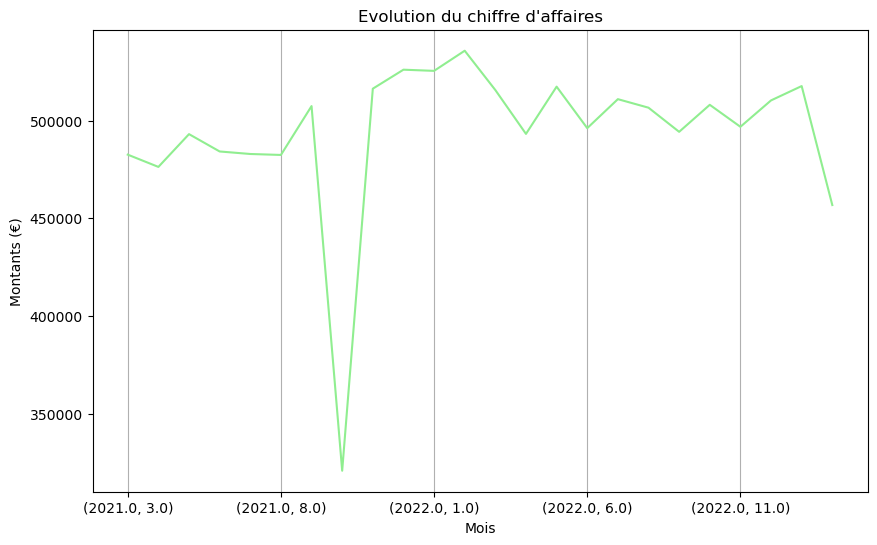

In [40]:
# On ajoute des colonnes pour l'année et le mois
data['Année'] = data['date'].dt.year
data['Mois'] = data['date'].dt.month

# On regroupe les données par année et mois, puis on calcule le chiffre d'affaires pour chaque groupe
ca_mensuel = data.groupby(['Année', 'Mois'])['price'].sum()
# On représente les résultats par un graphique pour plus de lisibilité 
plt.figure(figsize = (10,6))
ca_mensuel.plot(color= 'lightgreen')
plt.xlabel('Mois')
plt.ylabel('Montants (€)')
plt.title("Evolution du chiffre d'affaires")
plt.grid(axis='x')

In [41]:
print('le prix le plus fréquent est de',data['price'].mode())
print('le prix moyen est de ',round(data['price'].mean(),2),'€')
print ('la médiane est de ',data['price'].median(), '€')

le prix le plus fréquent est de 0    15.99
Name: price, dtype: float64
le prix moyen est de  17.45 €
la médiane est de  13.99 €


###  b) Répartition par catégories

In [42]:
# Repartition des références parmis les categories:
repartition_categories = data.groupby(["categ"])["id_prod"].count()
print("Répartitions des références par catégories:\n",repartition_categories)

# Prix moyen par categories:
prix_categories = data.groupby(["categ"])["price"].mean().round()
print("Prix moyen d'un livre selon sa catégorie:\n",prix_categories)

Répartitions des références par catégories:
 categ
0.0    415696
1.0    227171
2.0     36486
Name: id_prod, dtype: int64
Prix moyen d'un livre selon sa catégorie:
 categ
0.0    11.0
1.0    20.0
2.0    76.0
Name: price, dtype: float64


In [43]:
# Chiffre d'affaires par categorie
ca_par_categ=data.groupby('categ')['price'].sum().round()
print("le chiffre d'affaires par categorie est de :",ca_par_categ)

le chiffre d'affaires par categorie est de : categ
0.0    4422553.0
1.0    4653794.0
2.0    2780770.0
Name: price, dtype: float64


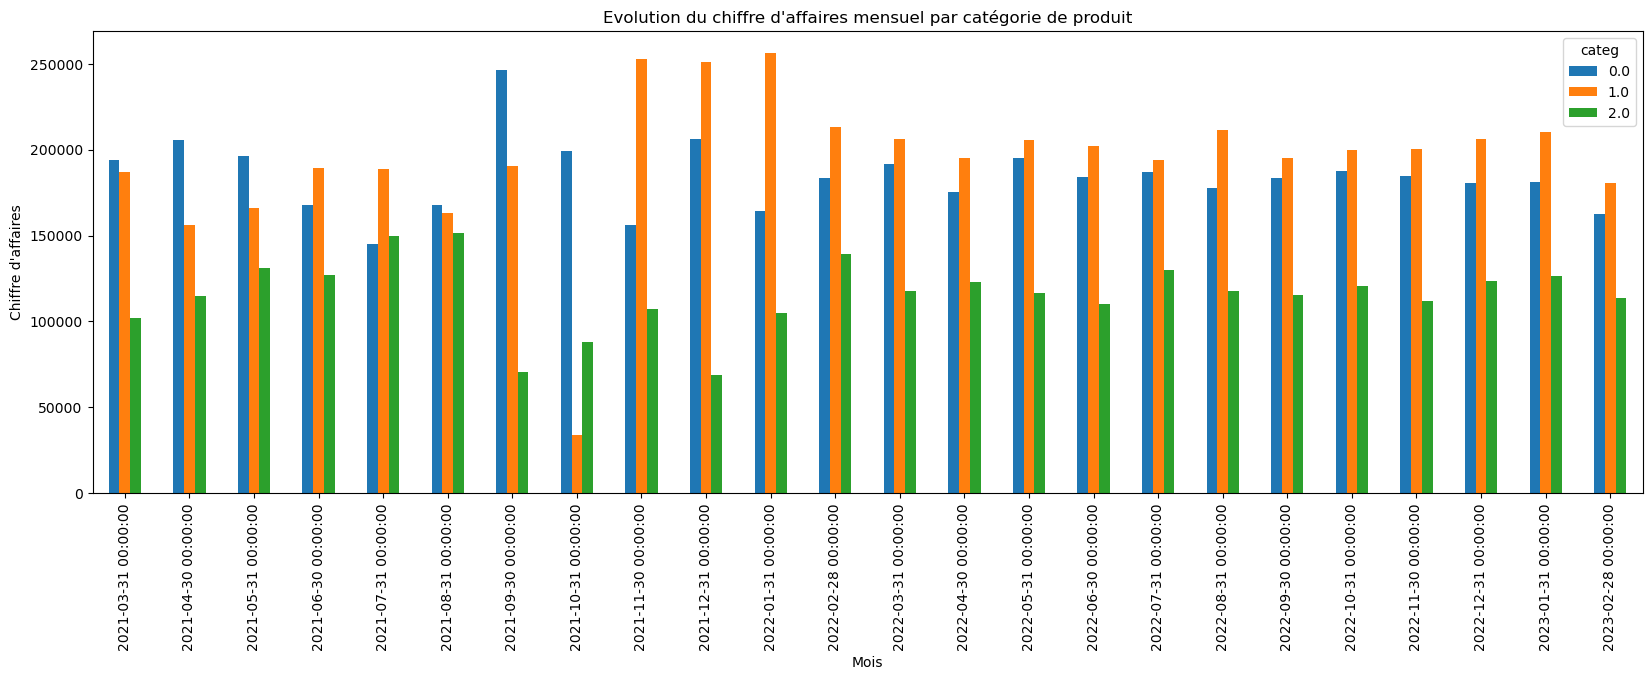

In [44]:
#Evolution du chiffre d'affaires mensuel par catégorie
data_mois_categ = data.groupby([pd.Grouper(key='date', freq='M'), 'categ']).sum().reset_index()

ax = data_mois_categ.pivot(index='date', columns='categ', values='price').plot(kind='bar', figsize=(20, 6))
ax.set_xlabel('Mois')
ax.set_ylabel("Chiffre d'affaires")
plt.title("Evolution du chiffre d'affaires mensuel par catégorie de produit")
plt.show()

Les ventes de la categorie 1 sont anormalement basses en octobre 2021, regardons cela plus en détail. 

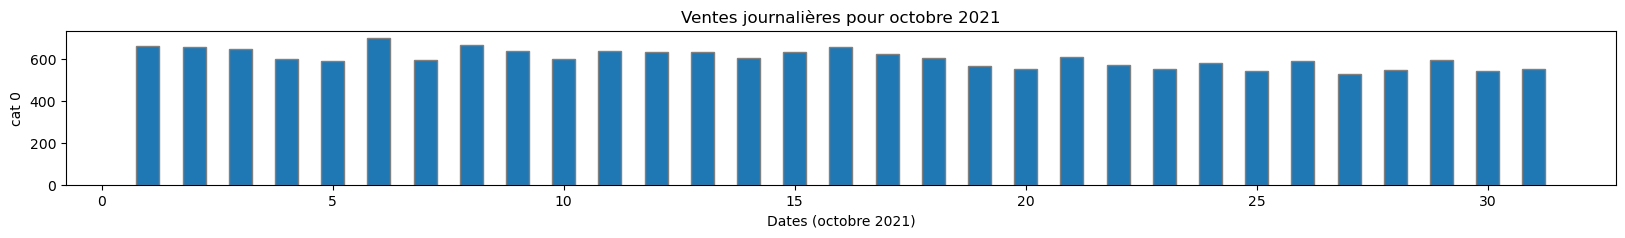

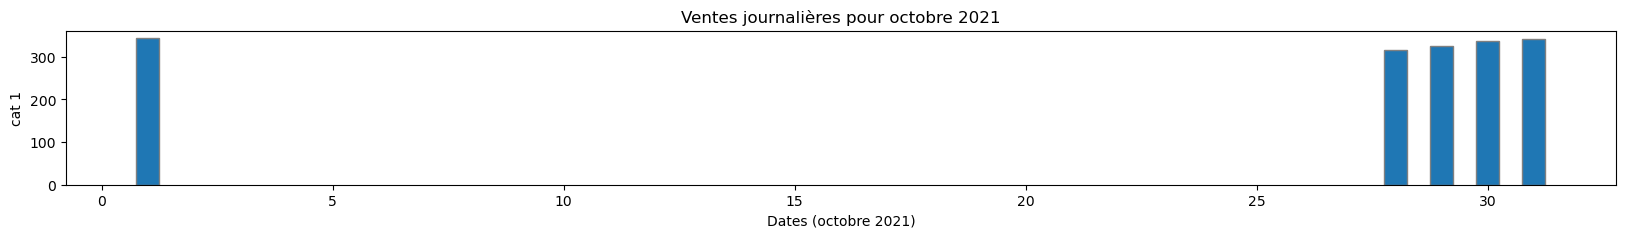

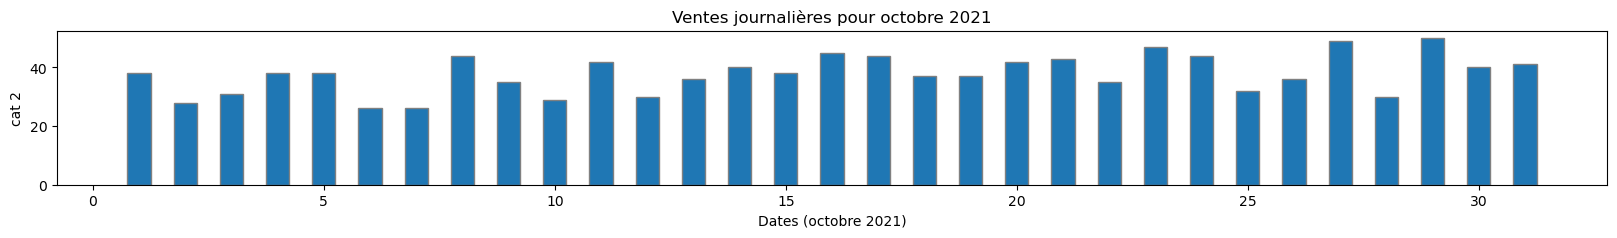

In [45]:
# Modification de la colonne date pour permettre une analyse journaliére
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day

# Analyse des ventes d'octobre
octobre_data = data.loc[(data["year"] == 2021) & (data["month"] == 10), ["day", "price","categ"]]
octobre_data = octobre_data.groupby(["day","categ"]).agg({"price":["sum","count"]}).reset_index()
octobre_data.columns = ["day", "categ", "ca", "volume"]
octobre_data = pd.pivot_table(octobre_data, columns=["categ"], index=["day"]).reset_index()
octobre_data.columns = ["day", 'ca_0', 'ca_1', 'ca_2', 'vol_0', 'vol_1', 'vol_2']

# Creation du graphique
for i, cat in enumerate([0,1,2]):
    plt.figure(figsize=(44,2))
    plt.subplot(1,2,2)
    plt.bar(octobre_data["day"], octobre_data[f'vol_{cat}'], width=0.5,edgecolor = "grey", linewidth = 1)
    plt.xlabel("Dates (octobre 2021)")
    plt.ylabel(f'cat {cat}')
    plt.title("Ventes journalières pour octobre 2021")
    plt.show()

Nous observons qu'il n'y a pas eu de vente de catégorie 1 entre le 2 et le 27 octobre 2021. Il s'agit certainement d'un probléme lors de l'enregistrement des valeurs dans notre système de traitement des données.

Afin d'avoir une analyse plus compléte et proche de la réalité, nous allons faire une imputation des données manquantes pour le mois d'octobre 2021 en utilisant la moyenne de septembre et novembre de la même année.

<Figure size 1000x600 with 0 Axes>

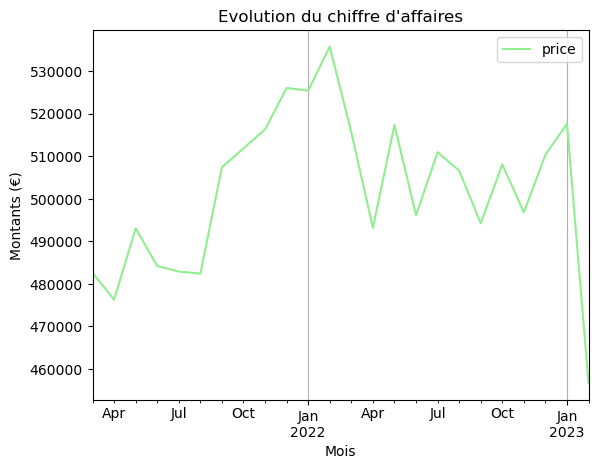

In [46]:
CAm = data[['date','price']].groupby(pd.Grouper(key='date', freq='M')).sum()
CA_moyenne_nov = (CAm.loc["2021-09-30", "price"] + CAm.loc["2021-11-30", "price"]) / 2

# On modifie les données d'octobre 2021
CAm.loc["2021-10-31", "price"] = CA_moyenne_nov

# Creation du graphique
plt.figure(figsize = (10,6))
CAm.plot(color= 'lightgreen')
plt.xlabel('Mois')
plt.ylabel('Montants (€)')
plt.title("Evolution du chiffre d'affaires")
plt.grid(axis='x')
#plt.xticks("Mois")

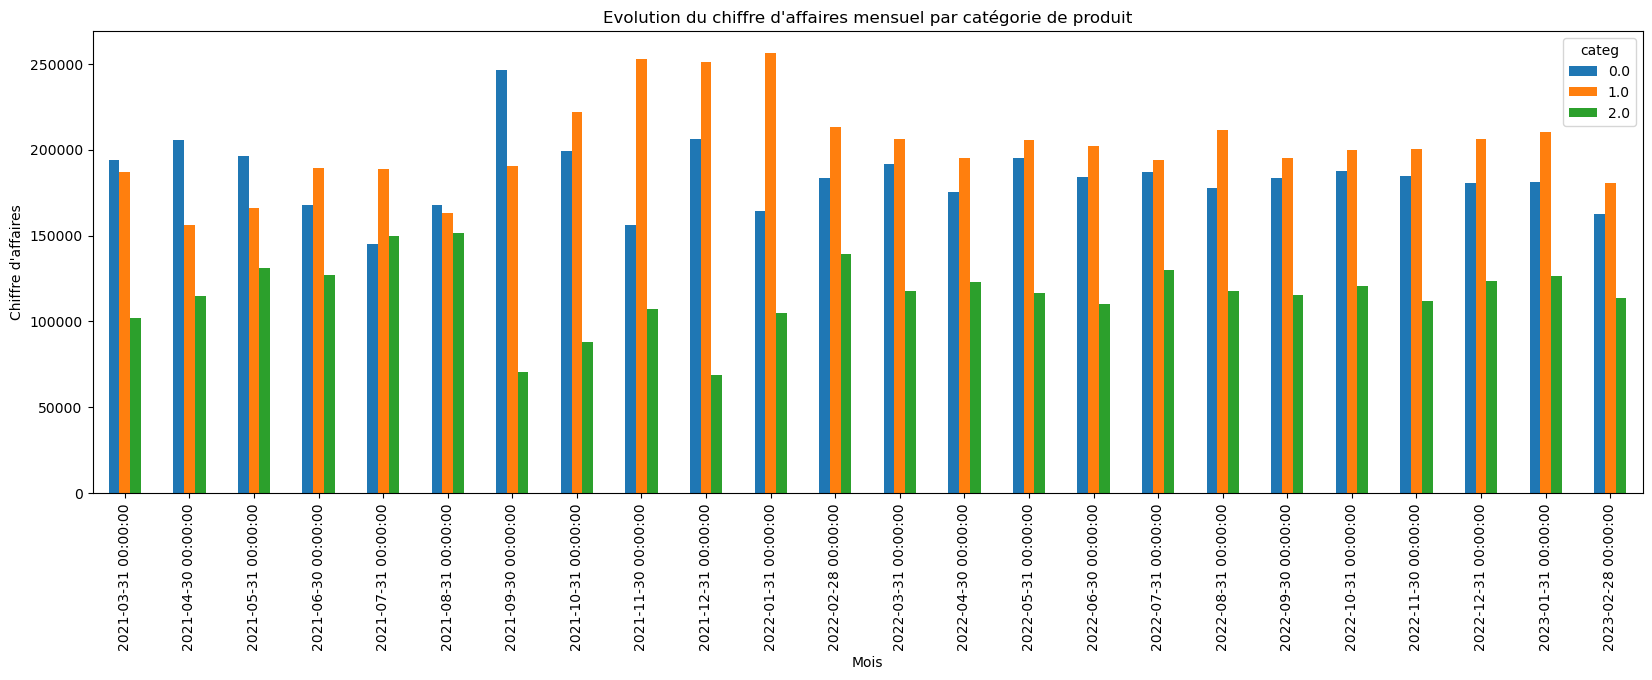

In [47]:
# Représentation graphique de l'Evolution du chiffre d'affaires mensuel par catégorie de produit

CAmc = data[['categ','date','price']].groupby([pd.Grouper(key='date',freq='M'), 'categ']).sum()
CAmc_moyenne_nov = (CAmc.loc["2021-09-30", "price"] + CAmc.loc["2021-11-30", "price"]) / 2
CAmc_moyenne_nov.iloc[1, ]

CAmc.loc[(CAmc.index.get_level_values(0)=="2021-10-31") & (CAmc.index.get_level_values(1)==1.0)]=CAmc_moyenne_nov.iloc[1, ]

g_data=CAmc.copy()
g_data['categ']= g_data.index.get_level_values(1)
g_data['date']= g_data.index.get_level_values(0)

ax = g_data.pivot(index='date', columns='categ', values='price').plot(kind='bar', figsize=(20, 6))
ax.set_xlabel('Mois')
ax.set_ylabel("Chiffre d'affaires")
plt.title("Evolution du chiffre d'affaires mensuel par catégorie de produit")
plt.show()

Chiffre d'affaires par catégorie
 categ
0.0    4422552.98
1.0    4653794.24
2.0    2780769.69
Name: price, dtype: float64


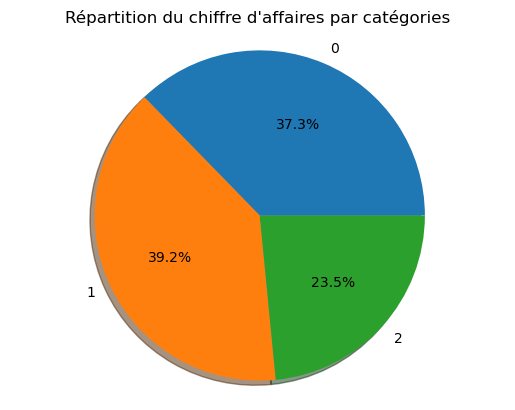

In [48]:
# Répartition du chiffre d'affaires par catégorie

ca_categ = data.groupby(data["categ"])["price"].sum().round(2)
print("Chiffre d'affaires par catégorie\n",ca_categ)

# Graphique:
fig1, ax1 = plt.subplots()
ax1.pie(ca_categ,
labels=["0","1","2"],
autopct="%1.1f%%",shadow=True)
ax1.axis("equal")
plt.title("Répartition du chiffre d'affaires par catégories")
plt.show()

### c) Saisonnalite et tendance

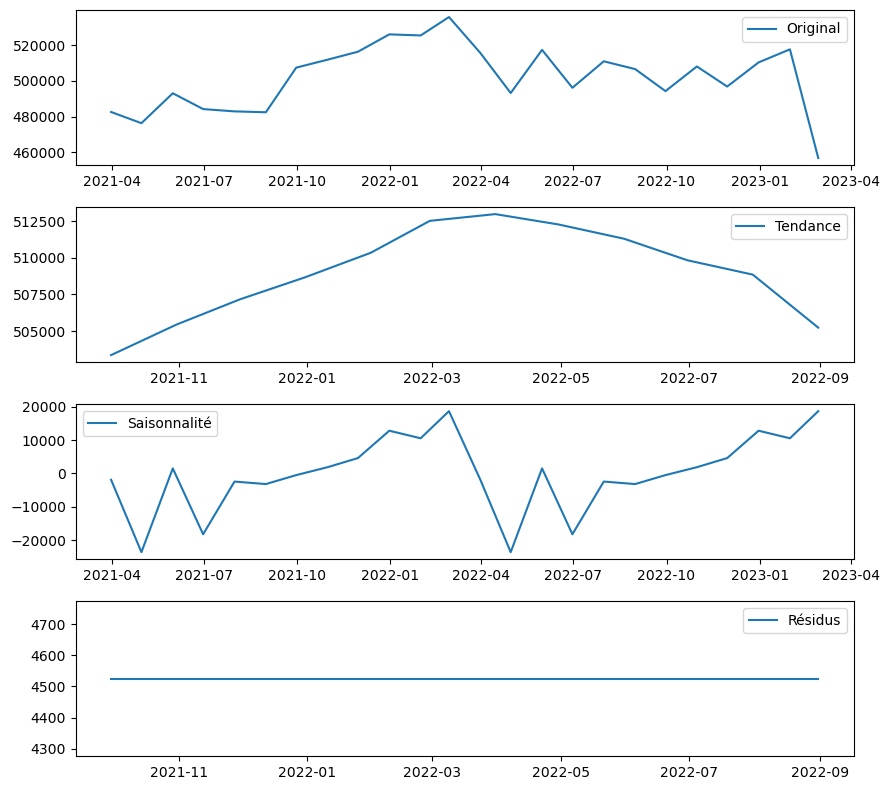

In [49]:
decomposition = seasonal_decompose(CAm, model='additive', period=12)
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid
fig = plt.figure(figsize=(9, 8))
plt.subplot(411)
plt.plot(CAm, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonality,label='Saisonnalité')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Résidus')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [50]:
# Decomposition en moyenne mobile:
MovingAverage = CAm.rolling(3).mean().round(2)
print(MovingAverage)

                price
date                 
2021-03-31        NaN
2021-04-30        NaN
2021-05-31  483952.37
2021-06-30  484493.86
2021-07-31  486696.78
2021-08-31  483147.80
2021-09-30  490884.73
2021-10-31  500535.04
2021-11-30  511833.27
2021-12-31  518039.24
2022-01-31  522560.71
2022-02-28  529032.54
2022-03-31  525561.27
2022-04-30  514816.45
2022-05-31  508689.70
2022-06-30  502193.92
2022-07-31  508114.16
2022-08-31  504527.77
2022-09-30  503901.72
2022-10-31  502938.79
2022-11-30  499683.07
2022-12-31  505039.67
2023-01-31  508235.53
2023-02-28  494891.49


Text(0.5, 1.0, "Moyenne mobile du chiffre d'affaires")

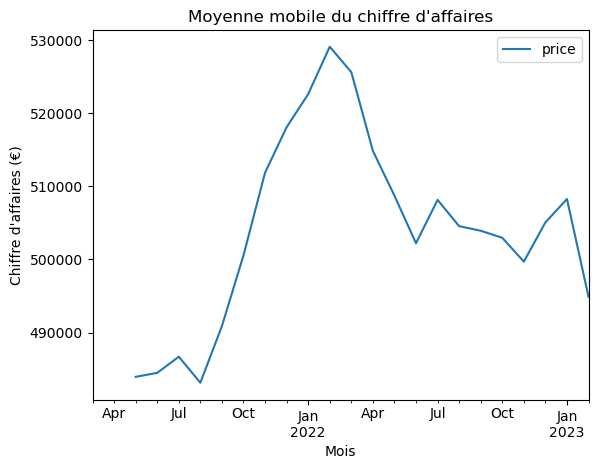

In [51]:
# Graphique moyenne mobile du chiffre d'affaires
MovingAverage.plot()
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaires (€)")
plt.title("Moyenne mobile du chiffre d'affaires")

### d) Répartition par références

In [52]:
#Top 10 CA par références 
ca_prod  = data.groupby("id_prod")["price"].sum()
print("10 références générant le plus de chiffre d'affaires : ")
ca_prod.sort_values(ascending=False).head(10)

10 références générant le plus de chiffre d'affaires : 


id_prod
2_159    94893.50
2_135    69334.95
2_112    65407.76
2_102    60736.78
2_209    56971.86
1_395    54356.25
1_369    54025.48
2_110    53846.25
2_39     53060.85
2_166    52449.12
Name: price, dtype: float64

In [53]:
# Flop 10 CA par références 
print("10 références générant le moins de chiffre d'affaires : ")
ca_prod.sort_values(ascending=True).head(10)

10 références générant le moins de chiffre d'affaires : 


id_prod
0_1620    0.80
0_1539    0.99
0_1014    1.15
0_1284    1.38
0_1780    1.67
0_310     1.94
0_1653    1.98
0_541     1.99
0_807     1.99
0_1601    1.99
Name: price, dtype: float64

indice de Gini: 0.745


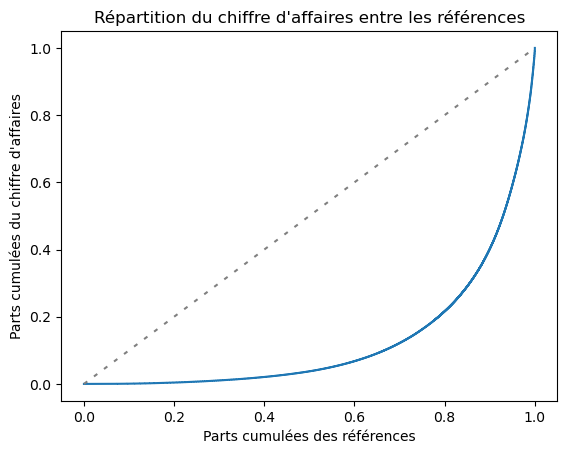

In [54]:
# Courbe de Lorentz: (Repartition du Chiffre d'affaires par références)
lorenz_ca_prod = np.cumsum(np.sort(ca_prod)) / ca_prod.sum()
lorenz_ca_prod = np.append([0], lorenz_ca_prod)
plt.plot(np.linspace(0,1,len(lorenz_ca_prod)), lorenz_ca_prod, drawstyle='steps-post'),
plt.plot(np.linspace(0,1,len(lorenz_ca_prod)), np.linspace(0,1,len(lorenz_ca_prod)),color ="grey", dashes=[2,4])
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des références")
plt.title("Répartition du chiffre d'affaires entre les références")
aire_ss_courbe_lorenz_ca_prod = lorenz_ca_prod[:-1].sum() / len(lorenz_ca_prod)
s_vente_prod = 0.5 - aire_ss_courbe_lorenz_ca_prod
gini_vente_prod = 2* s_vente_prod
print("indice de Gini:",round(gini_vente_prod,3))

L'indide de Gini 0,745 indique une forte inégalité du chiffre d'affaires entre les références

In [55]:
# Les références les plus vendues
nbr_ventes = data[["id_prod","price"]].groupby(["id_prod"]).count()
ca_prod = data[["id_prod","price"]].groupby(["id_prod"]).sum()
print("10 références les plus vendues")
print(nbr_ventes.sort_values(by='price', ascending= False).head(10))
print("10 références les moins vendues")
print(nbr_ventes.sort_values(by='price').head(10))

10 références les plus vendues
         price
id_prod       
1_369     2252
1_417     2189
1_414     2180
1_498     2128
1_425     2096
1_403     1960
1_412     1951
1_413     1945
1_406     1939
1_407     1935
10 références les moins vendues
         price
id_prod       
0_1498       1
0_322        1
0_1119       1
0_886        1
0_1025       1
0_1633       1
2_98         1
0_1780       1
2_23         1
0_1800       1


## Profils des clients

### a) Indicateurs

In [56]:
# top 10 de nos meilleurs clients
ca_par_client = data.groupby("client_id")["price"].sum().round(2)
print(ca_par_client.nlargest(10))
#data[data['client_id']=='c_3454']

client_id
c_1609    324033.35
c_4958    289760.34
c_6714    153669.32
c_3454    113673.13
c_3263      5276.87
c_1570      5271.62
c_2899      5214.05
c_2140      5208.82
c_7319      5155.77
c_8026      5094.31
Name: price, dtype: float64


Nos quatre meilleurs clients sont : deux hommes de 43 et 24 ans, une femme de 55 ans et un homme de 54 ans.
Ces quatre meilleurs clients sont sûrement des clients professionnels.

In [57]:
# Nombre d'achats et panier moyen par client:
nbr_achats_moy = data.groupby(["client_id"])["session_id"].count().mean()
panier_moyen = data.groupby(["client_id"])["price"].sum().mean()
print("Le nombre moyen d'achat par client est de", round(nbr_achats_moy,2))
print("Le CA moyen par client est de ",round(panier_moyen,2),"€")

Le nombre moyen d'achat par client est de 78.99
Le CA moyen par client est de  1378.64 €


In [58]:
# Nombre moyen d'achats par sessions:
print("Il y a eu",data["session_id"].nunique(),"sessions")
print("En moyenne une session aboutie à",round(data.groupby(["session_id","client_id"])["id_prod"].count().mean(),2),"achats")

Il y a eu 342315 sessions
En moyenne une session aboutie à 1.98 achats


indice de Gini: 0.447


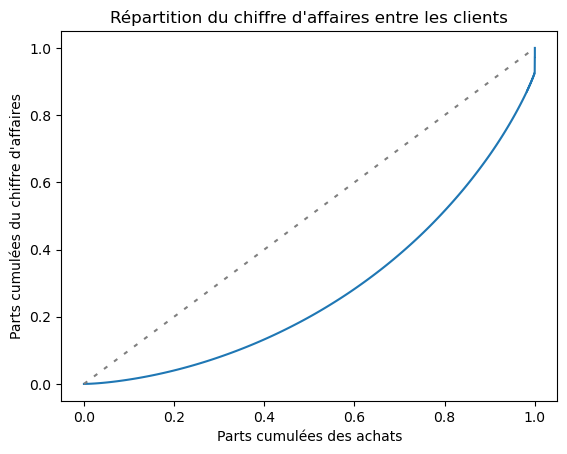

In [59]:
# Courbe de Lorentz: (repartition du CA par clients)
ca_par_client = data.groupby("client_id")["price"].sum()

lorenz_CA_client = np.cumsum(np.sort(ca_par_client)) / ca_par_client.sum()
lorenz_CA_client = np.append([0], lorenz_CA_client)
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), lorenz_CA_client, drawstyle="steps-post")
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), np.linspace(0,1,len(lorenz_CA_client)), color ="grey", dashes=[2,4])
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des achats")
plt.title("Répartition du chiffre d'affaires entre les clients")
aire_ss_courbe_CA_client = lorenz_CA_client[:-1].sum() / len(lorenz_CA_client)
S_ca_client = 0.5 - aire_ss_courbe_CA_client
gini_CA_client = 2*S_ca_client
print("indice de Gini:",round(gini_CA_client,3))

L'indice de Gini de 0.447 de la répartition du chiffre d'affaires entre les clients suggère une distribution relativement déséquilibrée de ce dernier. Il indique une concentration du chiffre d'affaires chez les clients les plus importants.


### b) Clients et âges

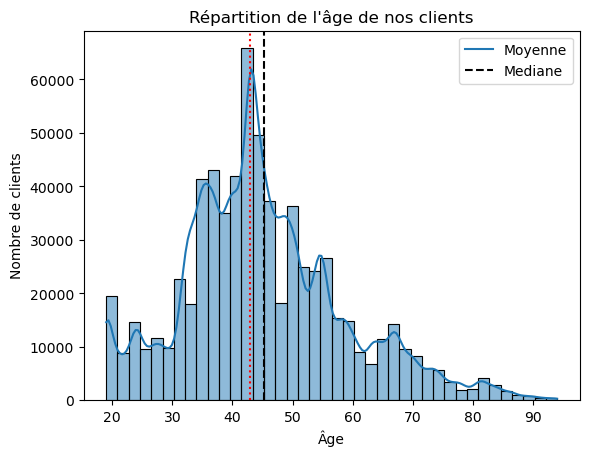

In [60]:
#data["age"].hist(bins=20)
sns.histplot(data["age"],bins=40,kde=True)
moyenne = data["age"].mean()
mediane = data["age"].median()

plt.axvline(data["age"].mean(), color='black', linestyle="--")
plt.axvline(data["age"].median(), color='red', linestyle=":")

plt.legend({"Moyenne":moyenne,"Mediane":mediane})

plt.xlabel("Âge")
plt.ylabel("Nombre de clients")
plt.title("Répartition de l'âge de nos clients")
plt.show()

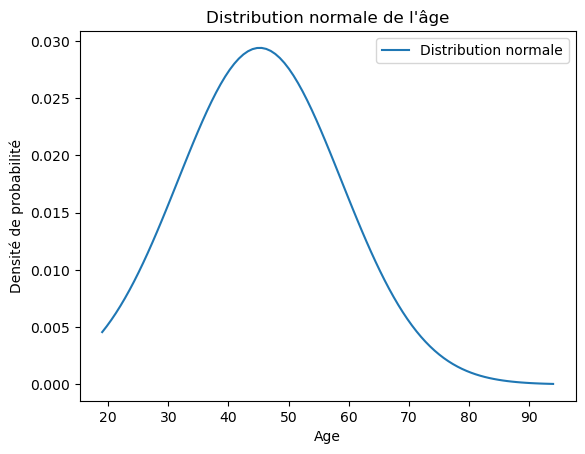

In [61]:
# Loi normale : Courbe de GAUSS 

# moyenne et écart type de la distribution d'âge
mu = data['age'].mean()
sigma = data['age'].std()
# Créer la distribution normale avec les paramètres mu et sigma
dist = norm(mu, sigma)

# Courbe de Gauss 
x = np.linspace(data['age'].min(), data['age'].max(), 100)
plt.plot(x, dist.pdf(x), label='Distribution normale')
plt.title("Distribution normale de l'âge")
plt.xlabel('Age')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.show()

La distibution de l'age de nos clients semble normale, le test de Shapiro nous permettra de confirmer cela.

In [62]:
# test de normalité de Shapiro
stat, p = shapiro(data["age"])
print("Statistique de test : ", stat)
print("P-value : ", p)

# Interprétation des résultats
alpha = 0.05
if p > alpha:
    print("La distribution de l'age' est normale (p > 0.05)")
else:
    print("La distribution de l'age' n'est pas normale (p <= 0.05)")

Statistique de test :  nan
P-value :  1.0
La distribution de l'age' est normale (p > 0.05)


C:\Users\Lenovo\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Lien entre l'âge des clients et le montant total des achats 

Text(0.5, 1.0, "Montant total des achats selon l'âge")

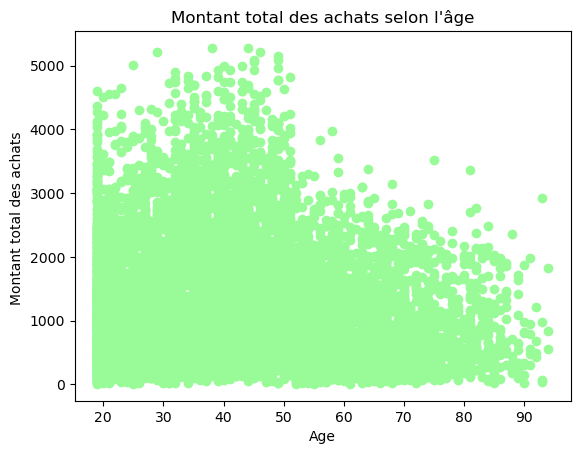

In [63]:
ca_par_client = data.groupby("client_id")["price"].sum().round(2)
ca_par_client =pd.DataFrame(ca_par_client)
ca_par_client = ca_par_client.merge(customers, on = "client_id")
# Les quatres plus gros clients professionnels peuvent être considérés comme des outliers(ils sont écartés de cette analyse)
ca_par_client= ca_par_client[ca_par_client['price']<100000]

# Graphique:
plt.scatter(ca_par_client.age, ca_par_client.price, color='palegreen')
plt.ylabel("Montant total des achats ")
plt.xlabel("Age")
plt.title("Montant total des achats selon l'âge")

In [64]:
# Correlation entre l'age et le montant total des achats:
print("Corrélation de Spearman:", st.spearmanr(ca_par_client.age.values,ca_par_client.price.values))


Corrélation de Spearman: SpearmanrResult(correlation=-0.18509546032566113, pvalue=4.071452149269866e-67)


In [65]:
pearsonr(ca_par_client['age'], ca_par_client['price'])

PearsonRResult(statistic=-0.18832132968113371, pvalue=1.8755334005767376e-69)

Le coefficient de Spearman de -0.0185 indique une faible correlation negative entre le chiffre d'affaire et l'age de nos clients. (-1 indique une corrélation négative, 0 indique l'absence de corrélation et +1 indique une corrélation positive).
Le P_valueindique que la corrélation est statistiquement significative (Valeurs P < 0,05). 
Cette analyse est confirmée par le test de Pearson

### Fréquence d'achat et âge

Text(0.5, 1.0, "Nombre d'achats selon l'âge")

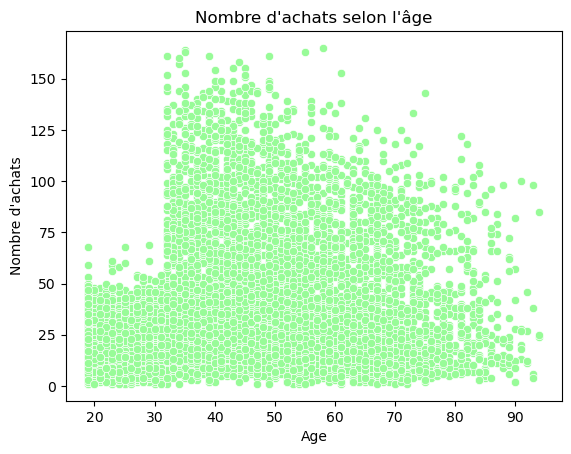

In [66]:
#Fréquence d'achat selon l'âge
freq_achat = data[['client_id', 'session_id']].drop_duplicates()
freq_achat= freq_achat.groupby('client_id').count()
freq_achat = freq_achat.merge(customers, on = "client_id")
# on enleve les outliers (clients professionnels)
freq_achat = freq_achat[freq_achat['session_id']<2000]
# Lien entre l'age et le nombre de session :
sns.scatterplot(data= freq_achat, x='age', y = 'session_id', color='palegreen')
plt.ylabel("Nombre d'achats")
plt.xlabel("Age")
plt.title("Nombre d'achats selon l'âge")

In [67]:
#Pearson
from scipy.stats import pearsonr
pearsonr(freq_achat['age'], freq_achat['session_id'])


PearsonRResult(statistic=0.1646077845831838, pvalue=2.8435326203886654e-53)

La corrélation de Pearson de 0,164 (varie de 1 à -1), suggère une corrélation positive faible entre les deux variables.
La p-value largement < à 0.05  indique une corrélation  significative.

In [68]:
print("Corrélation de Spearman:", st.spearmanr(freq_achat.age.values,freq_achat.session_id.values))

Corrélation de Spearman: SpearmanrResult(correlation=0.21234739496458024, pvalue=3.180991037736119e-88)


La corrélation de Spearman, confirme le test précédent.

### Panier moyen et âge

In [69]:
client_panier = data[['client_id','session_id', 'price']].groupby(['client_id', 'session_id']).sum()
client_panier_moyen = client_panier.groupby('client_id')['price'].mean()
client_panier_moyen = pd.DataFrame(client_panier_moyen)
client_panier_moyen = client_panier_moyen.merge(customers, on = "client_id")
client_panier_moyen.head()

,client_id,price,sex,birth,age
0,c_1,16.914545,m,1955,68
1,c_10,39.811765,m,1956,67
2,c_100,50.970000,m,1992,31
3,c_1000,24.321398,f,1966,57
4,c_1001,38.571489,m,1982,41


Text(0.5, 1.0, "Panier moyen selon l'age")

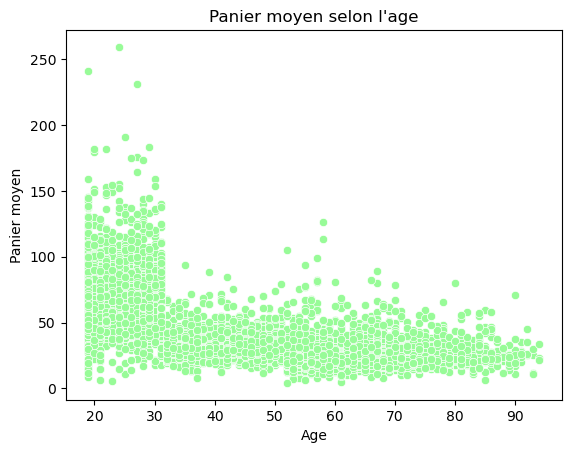

In [70]:
sns.scatterplot(data= client_panier_moyen, x='age', y = 'price', color='palegreen')
plt.ylabel("Panier moyen")
plt.xlabel("Age")
plt.title("Panier moyen selon l'age")

In [71]:
#Pearson
pearsonr(client_panier_moyen['age'], client_panier_moyen['price'])

PearsonRResult(statistic=-0.6169011051961064, pvalue=0.0)

Le coefficient de corrélation de Pearson est -0.6169 indique une corrélation négative modérée entre l'âge des clients et le prix moyen de leur panier. Cela suggère que les clients plus âgés ont tendance à dépenser moins que les clients plus jeunes.
La valeur p de 0,0 (<0,05) montre que la corrélation est significative et qu'il est peu probable que cette association soit due au hasard.

In [72]:
#spearman
print("Corrélation de Spearman:", st.spearmanr(client_panier_moyen.age.values,client_panier_moyen.price.values))

Corrélation de Spearman: SpearmanrResult(correlation=-0.7011081432425265, pvalue=0.0)


Le test de corrélation de Spearman nous confirme le resultat précédent.

In [73]:
bins = [0, 20, 30, 40, 50, 60, 70, 100]
data['tranche_age'] = pd.cut(data['age'], bins=bins)
# Repartition des achats par tranches d'ages:
repartition_achat_age = data.groupby(["tranche_age"])["price"].sum().round(2)
print("la répartition du montant des achats par tranche d'age est de : ", repartition_achat_age)
# Nombre d'achats par tranche d'age:
nombre_achat_age = data.groupby(["tranche_age"])["price"].count().round(2)
print("la répartition du nombre d'achats par tranche d'age est de : ", nombre_achat_age)
# Panier moyen par age :

# Montant moyen des achats par tranche d'age:
montant_moyen_achat_age = data.groupby(["tranche_age"])["price"].mean().round(2)
print("le montant moyen des achats par tranche d'age est de : ", montant_moyen_achat_age)

la répartition du montant des achats par tranche d'age est de :  tranche_age
(0, 20]       787209.47
(20, 30]     2277659.11
(30, 40]     2552776.54
(40, 50]     3005723.09
(50, 60]     1722206.54
(60, 70]      939624.72
(70, 100]     571122.17
Name: price, dtype: float64
la répartition du nombre d'achats par tranche d'age est de :  tranche_age
(0, 20]       19520
(20, 30]      54521
(30, 40]     181444
(40, 50]     227765
(50, 60]     105921
(60, 70]      55952
(70, 100]     34209
Name: price, dtype: int64
le montant moyen des achats par tranche d'age est de :  tranche_age
(0, 20]      40.33
(20, 30]     41.78
(30, 40]     14.07
(40, 50]     13.20
(50, 60]     16.26
(60, 70]     16.79
(70, 100]    16.70
Name: price, dtype: float64


Nous pouvons constater que : 
le panier moyen est plus elevé chez les moins de 30 ans, 
ce sont les 30-50 ans qui font le plus d'achats (60%) et 
que le chiffre d'affaires est le plus important pour la tranche 40-50 ans.
Il y a donc 3 types de clients selon l'age les moins de 30 ans, ceux entre 30 et 50 ans puis les plus de 50 ans.

### Lien entre l'âge des clients et les catégories de livres achetés

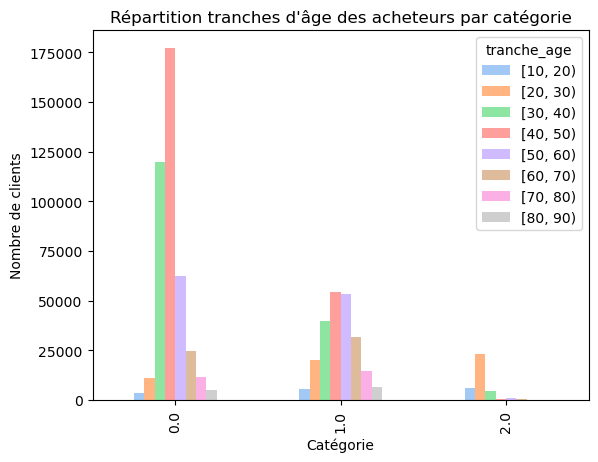

In [74]:
#répartition des catégories les plus achetées par age
data['tranche_age'] = pd.cut(data['age'], bins=range(10, 100, 10), right=False)
categ = data.groupby(['categ', 'tranche_age']).size().unstack(fill_value=0)
# Graphique
pastel_colors = sns.color_palette('pastel')
categ.plot.bar(color=pastel_colors)
plt.title("Répartition tranches d'âge des acheteurs par catégorie")
plt.xlabel('Catégorie')
plt.ylabel('Nombre de clients')
plt.show()

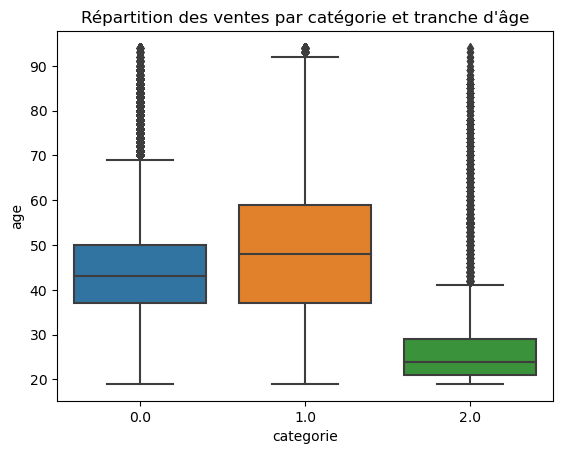

In [75]:
# Créer un boxplot 
sns.boxplot(x='categ', y='age',data=data)
plt.title('Répartition des ventes par catégorie et tranche d\'âge')
plt.xlabel('categorie')
plt.ylabel('age')
plt.show()

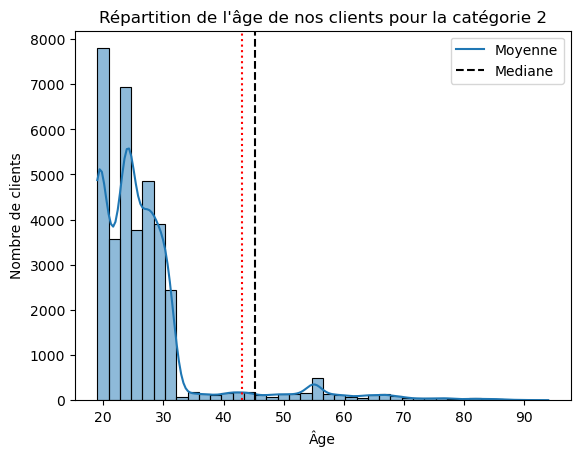

In [76]:
# Observation sur la catégorie 2
df_categ_0 = data.loc[data.categ==0.0, 'age'].dropna()
df_categ_1 = data.loc[data.categ==1.0, 'age'].dropna()
df_categ_2 = data.loc[data.categ==2.0, 'age'].dropna()
#graphique age de la catégorie 2
sns.histplot(df_categ_2,bins=40,kde=True)
moyenne = data["age"].mean()
mediane = data["age"].median()

plt.axvline(data["age"].mean(), color='black', linestyle="--")
plt.axvline(data["age"].median(), color='red', linestyle=":")

plt.legend({"Moyenne":moyenne,"Mediane":mediane})

plt.xlabel("Âge")
plt.ylabel("Nombre de clients")
plt.title("Répartition de l'âge de nos clients pour la catégorie 2")
plt.show()

On voit ici que les ages différent d'une catégorie à l'autre. Par exemple, l'age de la catégorie 2 est moins élevés et moins dispersés que ceux de la catégorie 1. Mais vérifions maintenant ces affirmations par les chiffres.

Test ANOVA catégorie et tranche d'age

In [77]:
fvalue, pvalue = f_oneway(df_categ_0,df_categ_1, df_categ_2)
# afficher les résultats
print('Valeur F : ', fvalue)
print('p-valeur : ', pvalue)

Valeur F :  45883.78058871316
p-valeur :  0.0


Ce test à un facteur permet d'analyser la variance moyenne des trois catégories. 
La valeur F élevée indique une grande différence entre les moyennes des groupes, tandis que la p-value nulle (0.0) suggère que cette différence est statistiquement significative, c'est-à-dire qu'il est peu probable qu'elle se produise par hasard.

Verifions la normalité de la distribution pour chacune des catégories

In [78]:
shapiro(df_categ_0)

C:\Users\Lenovo\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9367284774780273, pvalue=0.0)

In [79]:
shapiro(df_categ_1)

ShapiroResult(statistic=0.9893467426300049, pvalue=0.0)

In [80]:
shapiro(df_categ_2)

ShapiroResult(statistic=0.6679463386535645, pvalue=0.0)

Nous voyons que la valeur-p calculée pour le test statistique peut ne pas être précise ou exacte pour les échantillons de grande taille (N > 5000). 
Les trois tests sur la normalité de la  distribution suggèrent que les données ne suivent pas une distribution normale.
La valeur-p est de 0.0, donc inférieur à 0.05, ce qui signifie qu'on peut rejeter l'hypothèse nulle que les données suivent une distribution normale.

Faisons un test de Lavene afin de verifier l'égalité des variances des groupes.

In [81]:
stat, p_value = levene(df_categ_0,df_categ_1, df_categ_2)
print(f"Lavene's test statistic: {stat}")   
print(f"P-value: {p_value}")

Lavene's test statistic: 26091.73083988351
P-value: 0.0


La valeur-p est de 0.0, ce qui est inférieur au seuil de  0.05. L'hypothèse nulle selon laquelle les variances sont égales est rejetée.

Les hypothéses requises pour l'ANOVA ne sont vérifiées, nous utilisons donc un test non paramétrique : Kruskal-Wallis

In [82]:
print(type(categ.values))
print(st.kruskal(df_categ_0,df_categ_1, df_categ_2))

<class 'numpy.ndarray'>
KruskalResult(statistic=79350.86927924873, pvalue=0.0)


La valeur p de 0,0 suggère qu'il est extrêmement improbable que la différence entre les groupes soit due au hasard, ce qui signifie que les groupes sont très probablement différents les uns des autres.
On peut interpréter ce résultat comme une forte indication que les groupes présentent des différences significatives.

### c) Clients et genres

sex
f    4491
m    4132
Name: client_id, dtype: int64


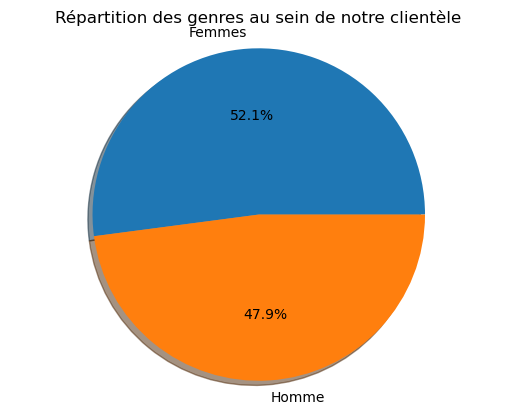

In [83]:
#repartition selon le genre 
repartition_genre = customers.groupby(["sex"])["client_id"].count()
print(repartition_genre)

# Graphique:
fig2, ax2 = plt.subplots()
ax2.pie(repartition_genre,
labels=["Femmes","Homme"],
autopct="%1.1f%%",
shadow=True)
ax2.axis("equal")
plt.title("Répartition des genres au sein de notre clientèle")
plt.show()

nombre total d'achats par genre sex
f    338402
m    340930
Name: price, dtype: int64
montant total des achats par genre sex
f    5861056.0
m    5995266.0
Name: price, dtype: float64
montant moyen des achats par genre sex
f    17.319803
m    17.585034
Name: price, dtype: float64


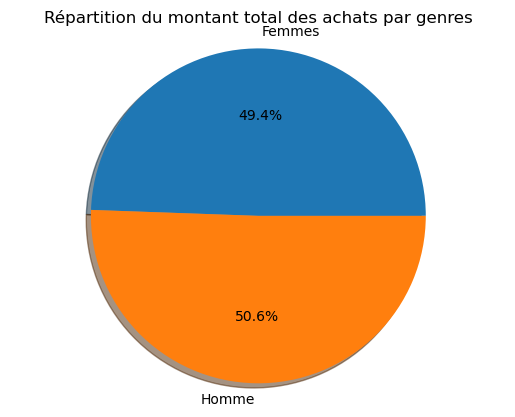

In [84]:
# Répartition par genre:

nbr_achats_genre = data.groupby(["sex"])["price"].count().round()
print("nombre total d'achats par genre", nbr_achats_genre)

repartition_achats_genre = data.groupby(["sex"])["price"].sum().round()
print("montant total des achats par genre", repartition_achats_genre)

moy_achats_genre = data.groupby(["sex"])["price"].mean()
print("montant moyen des achats par genre", moy_achats_genre)

# Graphique:
fig2, ax2 = plt.subplots()
ax2.pie(repartition_achats_genre ,
labels=["Femmes","Homme"],
autopct="%1.1f%%",
shadow=True)
ax2.axis("equal")
plt.title("Répartition du montant total des achats par genres")
plt.show()

### Lien entre genre d'un client et les catégories des livres achetés

In [85]:
categ_sex = pd.crosstab(data["sex"], data["categ"])
print(categ_sex)
#Le test du Chi²
chi2, pval, dof, expected = st.chi2_contingency(categ_sex)
print("Chi-square statistic = ", chi2)
print("P-value = ", pval)
#Le coefficient de corrélation de Cramer
n = categ_sex.sum().sum()
phi2 = chi2/n
r = min(categ_sex.shape) - 1
cramers_v = np.sqrt(phi2 / r)

print("Coefficient de corrélation de Cramer = ",cramers_v)

categ     0.0     1.0    2.0
sex                         
f      206220  114899  17283
m      209460  112270  19200
Chi-square statistic =  147.00253568681114
P-value =  1.1989607410166063e-32
Coefficient de corrélation de Cramer =  0.014710294817475282


Nous pouvons confirmer l’hypothèse d'une faible correlation entre le genre et les catégories. Le coefficient de Cramer proche de 0 indique une faible correlation (une valeur proche de 1 indiquerait une association forte), la P-value etant largement inférieure à 5% indique que cette correlation est fortement significative.

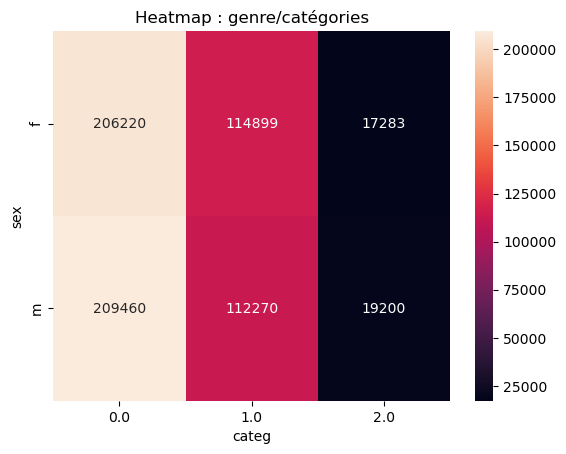

In [86]:
# créer la table de contingence
categ_sex = pd.crosstab(data["sex"], data["categ"])

# création la heatmap
sns.heatmap(categ_sex, annot=True, fmt="d")
plt.title("Heatmap : genre/catégories")
plt.show()

La heatmap nous confirme qu'il y a peu de variations entre le genre et les catégories. Les ventes de catégories ne dépendent pas du genre du client.